# Developing non-linear timing model code

In [3]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler

UsageError: Line magic function `%` not found.


In [45]:
from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl
from collections import OrderedDict

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
from enterprise.signals.parameter import function

import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

import libstempo as T2
from libstempo import toasim as LT

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Make data

In [5]:
parfile = ['./J1713+0747_tmtests.par']
ltpsrs = []
for p in parfile:
    obstimes = 53000.0 + np.linspace(0.0,10.0,300) * 365.25
    psr = LT.fakepulsar(parfile=p, obstimes=obstimes, toaerr=1.0, 
                        flags='-pta NANOGrav')
    LT.add_efac(psr,efac=1.0)
    psr.fit(iters=10)
    ltpsrs.append(psr)
#LT.createGWB(ltpsrs,Amp=8e-16,gam=13./3.)

## Plot data

In [6]:
psr = ltpsrs[0]

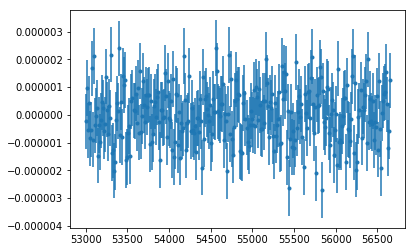

In [7]:
plt.errorbar(psr.toas(), psr.residuals(), yerr=1e-6*psr.toaerrs, fmt='.');
plt.show()

In [9]:
print(psr.pars()) # defaults to fitted parameters
print(psr.ndim)

('RAJ', 'DECJ', 'F0', 'F1', 'PMRA', 'PMDEC', 'PX', 'SINI', 'PB', 'T0', 'A1', 'OM', 'ECC', 'M2')
14


In [10]:
# look +/- 3 sigmas around the current value
x0, dx = psr['F1'].val, psr['F1'].err
xs = x0 + dx * np.linspace(-1000,1000,3)         

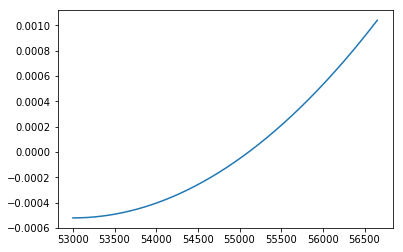

In [11]:
res=[]
for x in xs:
    psr['F1'].val = x
    res.append(psr.residuals())
psr['F1'].val = x0                       # restore the original value

plt.plot(psr.toas(), res[2]-res[0]);
plt.show()

## Load pulsars into `Pulsar` objects

In [12]:
epsrs = []
for p in ltpsrs:
    epsr = Pulsar(p, drop_t2pulsar=False)
    epsrs.append(epsr)

## Varying all parameters

In [13]:
epsr = epsrs[0]

In [14]:
# create new attribute for enterprise pulsar object
epsr.tmparams_orig = OrderedDict.fromkeys(epsr.t2pulsar.pars())
for key in epsr.tmparams_orig:
    epsr.tmparams_orig[key] = (epsr.t2pulsar[key].val, 
                               epsr.t2pulsar[key].err)

In [15]:
@function
def tm_delay(residuals, t2pulsar, tmparams_orig, tmparams, which='all'):
    """
    Compute difference in residuals due to perturbed timing model.
    
    :param residuals: original pulsar residuals from Pulsar object
    :param t2pulsar: libstempo pulsar object
    :param tmparams_orig: dictionary of TM parameter tuples, (val, err)
    :param tmparams: new timing model parameters, rescaled to be in sigmas
    :param which: option to have all or only named TM parameters varied
    
    :return: difference between new and old residuals in seconds
    """
    
    if which == 'all': keys = tmparams_orig.keys()
    else: keys = which
    
    # grab original timing model parameters and errors in dictionary
    orig_params = np.array([tmparams_orig[key] for key in keys])
    
    # put varying parameters into dictionary
    tmparams_rescaled = np.atleast_1d(np.double(orig_params[:,0] + 
                                                tmparams * orig_params[:,1]))
    tmparams_vary = OrderedDict(zip(keys, tmparams_rescaled))
                                    
    # set to new values
    t2pulsar.vals(tmparams_vary)
    new_res = np.double(t2pulsar.residuals().copy())
    
    # remmeber to set values back to originals 
    t2pulsar.vals(OrderedDict(zip(keys, 
                                  np.atleast_1d(np.double(orig_params[:,0])))))
    
    # Return the time-series for the pulsar
    return new_res - residuals

In [16]:
# find the maximum time span to set GW frequency sampling
tmin = epsr.toas.min()
tmax = epsr.toas.max()
Tspan = np.max(tmax) - np.min(tmin)

##### parameters and priors #####

# white noise parameters
# in this case we just set the value here since all efacs = 1 
# for the MDC data
efac = parameter.Uniform(0.1, 5.0)

# timing model parameters
tmparam_list = ['RAJ', 'DECJ', 'F0', 'F1', 
                'PMRA', 'PMDEC', 'PX', 'SINI', 
                'PB', 'A1', 'ECC', 'M2']
tm_params = parameter.Uniform(-5.0, 5.0, size=len(tmparam_list))

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)

# timing model
tm_func = tm_delay(tmparams=tm_params, which=tmparam_list)
tm = deterministic_signals.Deterministic(tm_func, name='timing model')

# full model is sum of components
model = ef + tm

# initialize PTA
pta = signal_base.PTA(model(epsr))

In [17]:
pta.params, pta.param_names#, psr.pars()

([J1713+0747_efac:Uniform(pmin=0.1, pmax=5.0),
  J1713+0747_timing model_tmparams:Uniform(pmin=-5.0, pmax=5.0)[12]],
 ['J1713+0747_efac',
  'J1713+0747_timing model_tmparams_0',
  'J1713+0747_timing model_tmparams_1',
  'J1713+0747_timing model_tmparams_2',
  'J1713+0747_timing model_tmparams_3',
  'J1713+0747_timing model_tmparams_4',
  'J1713+0747_timing model_tmparams_5',
  'J1713+0747_timing model_tmparams_6',
  'J1713+0747_timing model_tmparams_7',
  'J1713+0747_timing model_tmparams_8',
  'J1713+0747_timing model_tmparams_9',
  'J1713+0747_timing model_tmparams_10',
  'J1713+0747_timing model_tmparams_11'])

In [18]:
pta.get_lnlikelihood(np.random.randn(len(pta.param_names)))

-3831.2388355326157

### Test with MCMC

In [19]:
# dimension of parameter space
ndim = len(pta.param_names)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups
groups  = [range(0, ndim)]

# intialize sampler
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups,
                 outDir='./enterprise_nonlinear_timingmodel_tests/model_all/',
                resume=False)

In [20]:
# sampler for N steps
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.04 percent in 5.909786 s Acceptance rate = 0.5945

/Users/andrewkaiser/anaconda3/envs/enterprise/lib/python3.6/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 0.20 percent in 29.728778 s Acceptance rate = 0.334733Adding DE jump with weight 50
Finished 99.98 percent in 22911.384837 s Acceptance rate = 0.217492
Run Complete


In [35]:
# remmeber to set values back to originals 
#epsr.t2pulsar.vals(dict(zip(epsr.tmparams_orig.keys(), 
#                            np.array(epsr.tmparams_orig.values())[:,0])))
for s,f in epsr.tmparams_orig.items():
    epsr.t2pulsar.vals({s:f[0]})

In [36]:
# read chain
chain = np.loadtxt('./enterprise_nonlinear_timingmodel_tests/model_all/chain_1.txt')

In [37]:
chain.shape

(499900, 17)

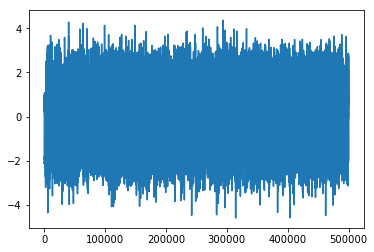

In [38]:
plt.plot(chain[:,3]);
plt.show()

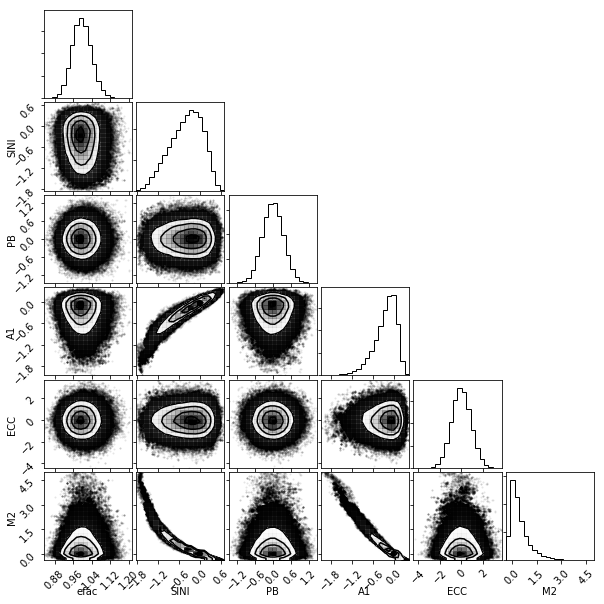

In [39]:
fig = corner.corner(chain[3000:,[0,8,9,10,11,12]], labels=['efac'] + tmparam_list[7:]);

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(16.5, 15.5)
fig.set_size_inches(8.5, 8.5)

## Attempting with enterprise_extensions

In [40]:
epsr = epsrs[0]
tmparam_list = ['RAJ', 'DECJ', 'F0', 'F1', 
                'PMRA', 'PMDEC', 'PX', 'SINI', 
                'PB', 'A1', 'ECC', 'M2']

pta = models.model_singlepsr_noise(epsr, tm_var=True, tm_linear=False, 
                                   tmparam_list=tmparam_list, white_vary=True, 
                                   wideband=True)

In [41]:
pta.params

[J1713+0747_flag_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_flag_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1713+0747_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J1713+0747_timing model_tmparams:Uniform(pmin=-5.0, pmax=5.0)[12]]

In [46]:
## Instanciate a collection of models
super_model = hypermodel.HyperModel({0:pta})

In [47]:
## Set up sampler
sampler = super_model.setup_sampler(resume=False, 
                                    outdir='./enterprise_nonlinear_timingmodel_tests/model_entext/')

Adding red noise prior draws...

Adding nmodel uniform distribution draws...



In [48]:
## Sample
N = int(5e6) # one mega-sample!
x0 = super_model.initial_sample()
sampler.sample(x0, N, AMweight=25, SCAMweight=40, DEweight=55)

/Users/andrewkaiser/anaconda3/envs/enterprise/lib/python3.6/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 0.20 percent in 25.958215 s Acceptance rate = 0.568911Adding DE jump with weight 55
Finished 59.26 percent in 59941.825686 s Acceptance rate = 0.516053

KeyboardInterrupt: 

In [50]:
# remmeber to set values back to originals 
#epsr.t2pulsar.vals(dict(zip(epsr.tmparams_orig.keys(), 
#                            np.array(epsr.tmparams_orig.values())[:,0])))
# read chain
chain = np.loadtxt('./enterprise_nonlinear_timingmodel_tests/model_entext/chain_1.txt')

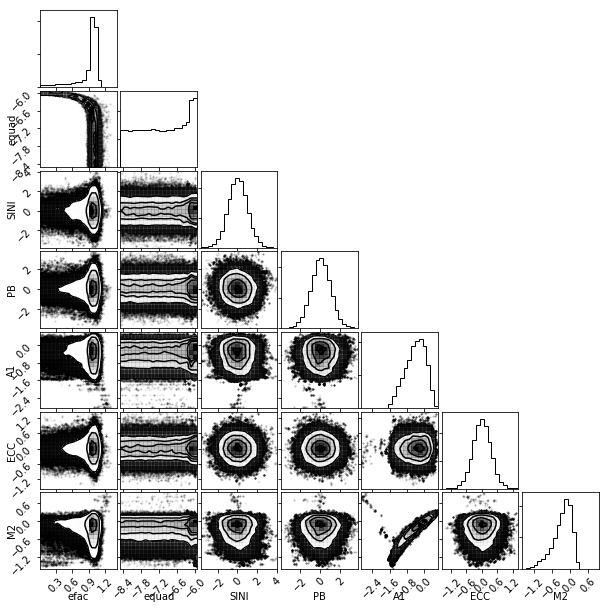

In [51]:
fig = corner.corner(chain[3000:,[0,1,9,10,11,12,13]], labels=['efac', 'equad'] + tmparam_list[7:]);

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(16.5, 15.5)
fig.set_size_inches(8.5, 8.5)